# Guided Grad-CAM

Guided Grad-CAM is an attribution method which combines both guided backprop and Grad-CAM. Guided Grad-CAM improves on both methods by using the best features of both methods. The high resolution of guided backprop is combined with the class localization abilitly of Grad-CAM to produce an algorithm superior to both. The gradients required for both methods can be calculated in a single backwards pass, which helps keep the algorithm fast. Unfortunately the algorithm required far more code since the code for both Grad-CAM and guided backprop are needed. Repeated descriptions from both algorithms have been kept to a minimum to save space, so its recommended to read both the "grad-cam" and "guided_packprop" notebooks before continuing.  


For more technical information on the Guided Grad-CAM method see: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import custom_vjp
import flax.linen as nn
from flax.core.frozen_dict import freeze
import jax
from jax import random
from jax import grad
from keras.utils import data_utils

2022-11-21 10:36:28.042424: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-21 10:36:34.560163: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:
2022-11-21 10:36:34.597284: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:
2022-11-21 10:36:34.597335: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned a

### Load training data
Check if the training data exists. If not, automatically download it.

In [2]:
data_dir = os.path.abspath("./digit-recognizer")
os.makedirs(data_dir, exist_ok=True)
train_data_path = f"{data_dir}/train.zip"
train_data_url = "https://huggingface.co/datasets/ChristianOrr/mnist/resolve/main/train.zip"

if not os.path.exists(train_data_path):
    print("Downloading training data...")
    data_utils.get_file(
        train_data_path, 
        train_data_url, 
        extract=True, 
        cache_dir=data_dir
        )

data_df = pd.read_csv('./digit-recognizer/datasets/train.csv')

In [3]:
val_size = 1000
# Only shuffle training data
np.random.shuffle(data_df[val_size:].values)
m, n = data_df.shape
Y = jnp.array(data_df["label"])
data_df = data_df.drop("label", axis=1)
X = jnp.array(data_df)


X_train = X[val_size:]
X_train = X_train / 255.
Y_train = Y[val_size:]

X_val = X[:val_size]
X_val = X_val / 255.
Y_val = Y[:val_size]

### Define the classification model

In [4]:
class _forward_fn(nn.Module):

    @nn.compact
    def __call__(self, x):
        batch_size = x.shape[0]
        # Unflatten for the convolution layers
        x = x.reshape(batch_size, 28, 28, 1)
        conv_layers = nn.Sequential([
            nn.Conv(features=16, kernel_size=(3, 3), padding="VALID", use_bias=False), jax.nn.relu,
            nn.Conv(features=32, kernel_size=(3, 3), padding="VALID", use_bias=False), jax.nn.relu,  
        ])
        x = conv_layers(x)
        # Use perturb to extract the gradients for the final conv layer
        x = self.perturb("conv_1", x)
        # Save the final convolution layer as an intermediate so 
        # it can be accessed for the cam algorithm
        self.sow("intermediates", "final_conv_layer", x)
        # Flatten
        x = x.reshape((batch_size, -1))
        x = nn.Dense(10)(x)
        return jax.nn.softmax(x)

# Create the model object
forward_fn = _forward_fn()
# Display the model details
dummy_x = X_train[:5]
rng_key = random.PRNGKey(64)
print(forward_fn.tabulate(rng_key, dummy_x))


                              _forward_fn Summary                               
┏━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃ path     ┃ module   ┃ inputs   ┃ outputs   ┃ params   ┃ perturba… ┃ interme… ┃
┡━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│          │ _forwar… │ float32… │ float32[… │          │ conv_1:   │ final_c… │
│          │          │          │           │          │ float32[… │ -        │
│          │          │          │           │          │           │ float32… │
│          │          │          │           │          │ 92,160    │          │
│          │          │          │           │          │ (368.6    │ 92,160   │
│          │          │          │           │          │ KB)       │ (368.6   │
│          │          │          │           │          │           │ KB)      │
├──────────┼──────────┼──────────┼───────────┼──────────┼───────────┼──────────┤
│ Sequent… │ Sequent… │ flo

### Define the loss function and update method

In [5]:
def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[..., None] == jnp.arange(k), dtype)

def loss_fn(params, perturbations, X, Y):
    variables = {
        'params': params,
        'perturbations': perturbations
    }
    logits = forward_fn.apply(variables, X)
    one_hot_Y = one_hot(Y, 10)
    loss = -jnp.sum(one_hot_Y * jnp.log(logits)) / m
    return loss

def update_rule(param, update):
    return param - 0.1 * update

def update_params(params, perturbations, alpha, X, Y):
    grads = grad(loss_fn, argnums=0)(params, perturbations, X, Y)
    params = jax.tree_util.tree_map(update_rule, params, grads)
    return params


### Train the model

In [6]:
def get_predictions(logits):
    return jnp.argmax(logits, axis=1)

def get_accuracy(predictions, Y):
    return jnp.mean(predictions == Y)

def gradient_descent(X, Y, batch_size, alpha, epochs):
    dataset_size = len(X)
    steps_per_epoch = dataset_size // batch_size

    rng = jax.random.PRNGKey(42)
    variables = forward_fn.init(rng, X[0: batch_size, :])
    params, perturbations = variables["params"], variables["perturbations"]
    for epoch in range(epochs):
        dataset_step = epoch % steps_per_epoch
        dataset_index = dataset_step * batch_size
        input = X[dataset_index: dataset_index + batch_size, :]
        label = Y[dataset_index: dataset_index + batch_size, ...]
        params = update_params(params, perturbations, alpha, input, label)
        if epoch % 10 == 0:
            print("Iteration: ", epoch)
            logits = forward_fn.apply({'params': params, 'perturbations': perturbations}, input)
            predictions = get_predictions(logits)
            print(get_accuracy(predictions, label))
    return params

In [7]:
params = gradient_descent(X_train, Y_train, 2000, 0.10, 200)

2022-11-21 10:37:24.582558: W external/org_tensorflow/tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.47GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


Iteration:  0
0.128
Iteration:  10
0.71800005
Iteration:  20
0.79600006
Iteration:  30
0.82250005
Iteration:  40
0.83400005
Iteration:  50
0.84900004
Iteration:  60
0.8615
Iteration:  70
0.859
Iteration:  80
0.87100005
Iteration:  90
0.87000006
Iteration:  100
0.87700003
Iteration:  110
0.87850004
Iteration:  120
0.883
Iteration:  130
0.88150007
Iteration:  140
0.887
Iteration:  150
0.883
Iteration:  160
0.89350003
Iteration:  170
0.8855
Iteration:  180
0.89650005
Iteration:  190
0.8880001


### Create Guided Relu

For a detailed description of the guided relu layer see the guided backprop notebook.

In [8]:
@custom_vjp
def guided_relu(x):
    return jax.nn.relu(x)

def guided_relu_fwd(x):
    residual = x
    primal = guided_relu(x)

    return primal, residual

def guided_relu_bwd(residual, grad):
    # Derivative of relu is 1 for values > 0 and 0 otherwise
    # Using relu devivative for both residuals and grads
    grad_gate = jnp.float32(grad > 0)
    residual_gate = jnp.float32(residual > 0)
    output = residual_gate * grad_gate * grad
    return (output, ) 

guided_relu.defvjp(guided_relu_fwd, guided_relu_bwd)

### Create the guided model

Now that we have the guided relu layers we can swap them with the relu layers in the classification model. The model architecture is identical to the one trained previously so we can use its trained parameters.

In [9]:
class _guided_forward_fn(nn.Module):

    @nn.compact
    def __call__(self, x):
        batch_size = x.shape[0]
        # Unflatten for the convolution layers
        x = x.reshape(batch_size, 28, 28, 1)
        conv_layers = nn.Sequential([
            nn.Conv(features=16, kernel_size=(3, 3), padding="VALID", use_bias=False), guided_relu,
            nn.Conv(features=32, kernel_size=(3, 3), padding="VALID", use_bias=False), guided_relu,  
        ])
        x = conv_layers(x)
        # Use perturb to extract the gradients for the final conv layer
        x = self.perturb("conv_1", x)
        # Save the final convolution layer as an intermediate so 
        # it can be accessed for the cam algorithm
        self.sow("intermediates", "final_conv_layer", x)
        # Flatten
        x = x.reshape((batch_size, -1))
        x = nn.Dense(10)(x)
        return jax.nn.softmax(x)

# Create the model object
guided_forward_fn = _guided_forward_fn()
# Display the model details
dummy_x = X_train[:5]
rng_key = random.PRNGKey(64)
print(guided_forward_fn.tabulate(rng_key, dummy_x))


                           _guided_forward_fn Summary                           
┏━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┓
┃ path     ┃ module   ┃ inputs   ┃ outputs  ┃ params    ┃ perturb… ┃ intermed… ┃
┡━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━┩
│          │ _guided… │ float32… │ float32… │           │ conv_1:  │ final_co… │
│          │          │          │          │           │ float32… │ -         │
│          │          │          │          │           │          │ float32[… │
│          │          │          │          │           │ 92,160   │           │
│          │          │          │          │           │ (368.6   │ 92,160    │
│          │          │          │          │           │ KB)      │ (368.6    │
│          │          │          │          │           │          │ KB)       │
├──────────┼──────────┼──────────┼──────────┼───────────┼──────────┼───────────┤
│ Sequent… │ Sequent… │ flo

### Create new loss function with guided model

A new loss function containing the model with guided relu layers is required when performing gradient calculations for the attribution maps.

In [10]:
def guided_loss_fn(params, perturbations, X, Y):
    variables = {
        'params': params,
        'perturbations': perturbations
    }
    logits = guided_forward_fn.apply(variables, X)
    one_hot_Y = one_hot(Y, 10)
    loss = -jnp.sum(one_hot_Y * jnp.log(logits)) / m
    return loss

### Display predictions and attribution maps

For this method we need both the upscaled Grad-CAM map and guided grads. The upscaled Grad-CAM map and guided grads are then multiplied to get the final attribution map. As shown in the grad-cam notebook we need the final convolution layer gradients. To save performing two backward passes we can extract both the guided grads and final conv grads in a single pass by performing both gradient calculations on the guided loss function. This ensures the speed of the method will be similar to Grad-CAM.


In [11]:
def make_predictions(X, params, perturbations):
    logits, state = forward_fn.apply({'params': params, 'perturbations': perturbations}, X, mutable='intermediates')
    predictions = get_predictions(logits)
    return predictions, state

def prep_image(image):
    # Normalize the gradient values to be between 0-1
    max_val= np.max(image)
    min_val = np.min(image)
    image = (image - min_val) / (max_val - min_val)
    # Convert the grads to uint8 for displaying
    image = np.uint8(image * 255)
    return image   

def display_prediction(index, params):
    current_image = X_val[None, index]
    rng = jax.random.PRNGKey(42)
    init_variables = forward_fn.init(rng, current_image)
    init_perturbations = init_variables["perturbations"]
    prediction, state = make_predictions(X_val[None, index], params, init_perturbations)

    label = Y_val[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    display_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(display_image, interpolation='nearest')
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Extract final conv layers values
    final_conv_layer = state["intermediates"]["final_conv_layer"][0][0]
    # Get final conv gradients
    perturbations = freeze({"conv_1": final_conv_layer})
    # Extract conv grads for grad-cam and input grads for guided backprop using the guided relu loss
    final_conv_grads, guided_grads = grad(guided_loss_fn, argnums=(1, 2))(params, perturbations, current_image, label)
    final_conv_grads = final_conv_grads["conv_1"]
    # Get weights using global average pooling
    weights = jnp.mean(final_conv_grads, axis=(0, 1))
    # Get the weighted sum of all the filters
    cam = jnp.dot(final_conv_layer, weights)
    cam = prep_image(cam)
    # Upscale cam so its the same resolution as the guided grads
    cam = jax.image.resize(cam, shape=(28, 28), method="bilinear")
    # Prepare guided grads
    guided_grads = guided_grads.reshape((28, 28))
    guided_grads = prep_image(guided_grads)
    # Multiply cam and guided grads to get attributions
    attributions = guided_grads * cam

    plt.gray()
    plt.imshow(attributions, interpolation='nearest')
    plt.axis('off')
    plt.title("Attribution Map")
    plt.show()

Prediction:  [1]
Label:  1


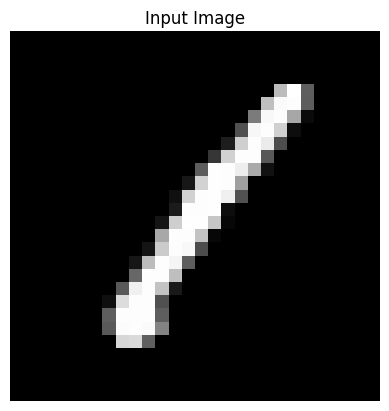

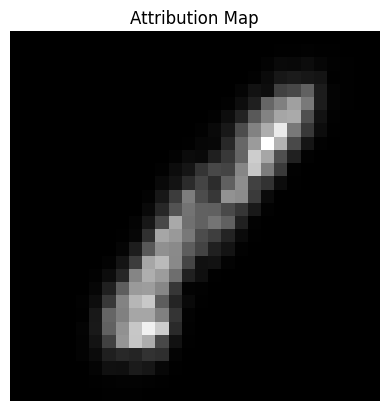

Prediction:  [2]
Label:  4


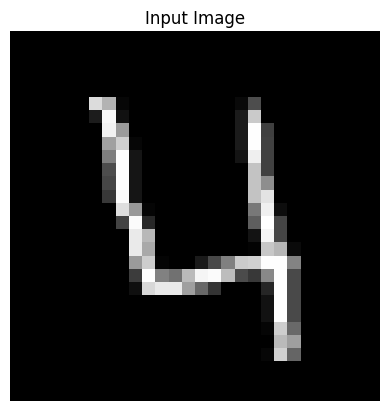

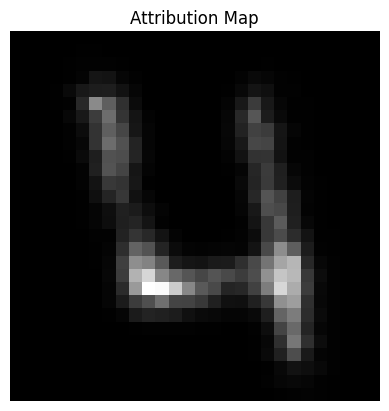

Prediction:  [0]
Label:  0


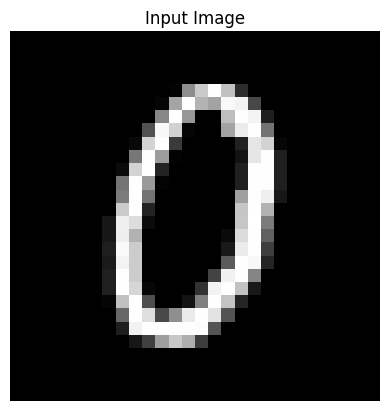

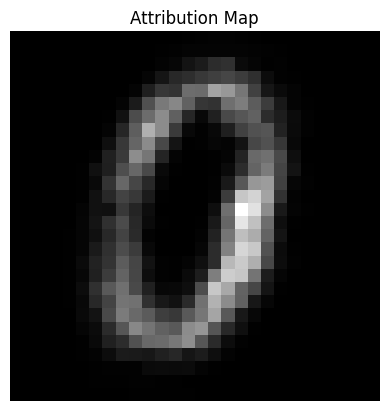

Prediction:  [5]
Label:  5


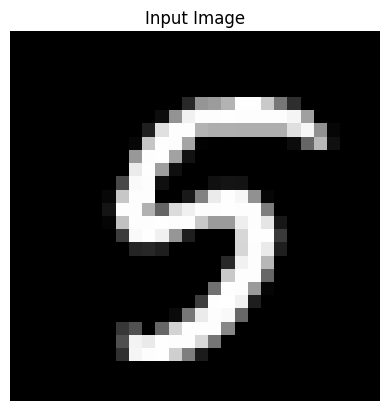

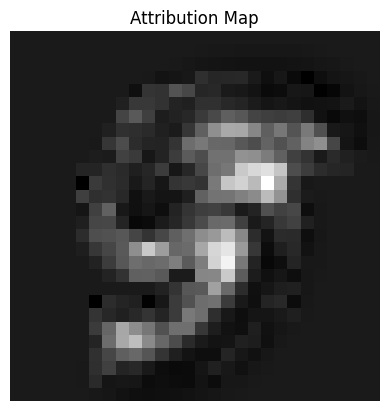

Prediction:  [8]
Label:  8


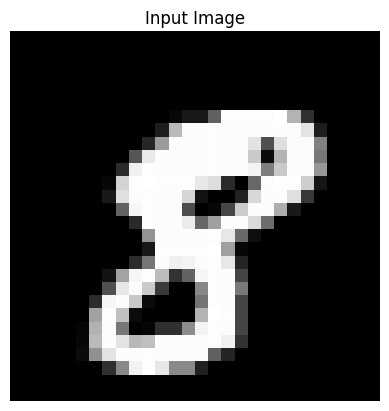

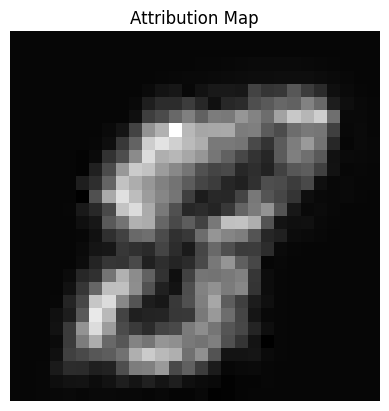

Prediction:  [7]
Label:  7


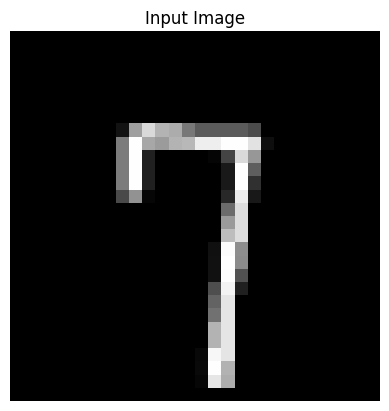

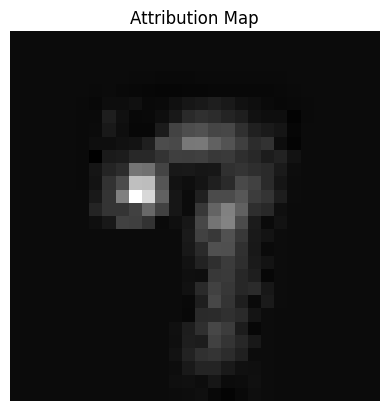

In [12]:
display_prediction(0, params)
display_prediction(3, params)
display_prediction(5, params)
display_prediction(8, params)
display_prediction(10, params)
display_prediction(50, params)